# 🔭 Assignment: Measuring Cosmological Parameters Using Type Ia Supernovae
---

## Index
Part 1: Code    
Part 2: Questions   
Part 3: Analysis & Notes    
Part 4: References  

---

## Part 1: Code
---

## 📦 Getting Started: Setup and Libraries

Necessary Python libraries:

- `numpy`, `pandas` — for numerical operations and data handling
- `matplotlib` — for plotting graphs
- `scipy.optimize.curve_fit` and `scipy.integrate.quad` — for fitting cosmological models and integrating equations
- `astropy.constants` and `astropy.units` — for physical constants and unit conversions


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.integrate import quad
from astropy.constants import c
from astropy import units as u

## 📂 Load the Pantheon+SH0ES Dataset

We now load the observational supernova data from the Pantheon+SH0ES sample. This dataset includes calibrated distance moduli $\mu$, redshifts corrected for various effects, and uncertainties.

### Instructions:
- Make sure the data file is downloaded from [Pantheon dataset](https://github.com/PantheonPlusSH0ES/DataRelease/blob/main/Pantheon%2B_Data/4_DISTANCES_AND_COVAR/Pantheon%2BSH0ES.dat) and available locally.
- We use `delim_whitespace=True` because the file is space-delimited rather than comma-separated.
- Commented rows (starting with `#`) are automatically skipped.

We will extract:
- `zHD`: Hubble diagram redshift
- `MU_SH0ES`: Distance modulus using SH0ES calibration
- `MU_SH0ES_ERR_DIAG`: Associated uncertainty


In [2]:
# Local file path
file_path = r"C:\Users\praya\Downloads\Pantheon+SH0ES.dat"

# Load the file
df = pd.read_csv(file_path, delim_whitespace=True)

# See structure
df.head()


C:\Users\praya\AppData\Local\Temp\ipykernel_20976\4149607621.py:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True)


,CID,IDSURVEY,zHD,zHDERR,zCMB,zCMBERR,zHEL,zHELERR,m_b_corr,m_b_corr_err_DIAG,...,PKMJDERR,NDOF,FITCHI2,FITPROB,m_b_corr_err_RAW,m_b_corr_err_VPEC,biasCor_m_b,biasCorErr_m_b,biasCor_m_b_COVSCALE,biasCor_m_b_COVADD
0,2011fe,51,0.00122,0.00084,0.00122,0.00002,0.00082,0.00002,9.74571,1.516210,...,0.1071,36,26.8859,0.864470,0.0991,1.4960,0.0381,0.005,1.0,0.003
1,2011fe,56,0.00122,0.00084,0.00122,0.00002,0.00082,0.00002,9.80286,1.517230,...,0.0579,101,88.3064,0.812220,0.0971,1.4960,-0.0252,0.003,1.0,0.004
2,2012cg,51,0.00256,0.00084,0.00256,0.00002,0.00144,0.00002,11.47030,0.781906,...,0.0278,165,233.5000,0.000358,0.0399,0.7134,0.0545,0.019,1.0,0.036
3,2012cg,56,0.00256,0.00084,0.00256,0.00002,0.00144,0.00002,11.49190,0.798612,...,0.0667,55,100.1220,0.000193,0.0931,0.7134,0.0622,0.028,1.0,0.040
4,1994DRichmond,50,0.00299,0.00084,0.00299,0.00004,0.00187,0.00004,11.52270,0.880798,...,0.0522,146,109.8390,0.988740,0.0567,0.6110,0.0650,0.009,1.0,0.006


## 🧾 Preview Dataset Columns

Before diving into the analysis, let’s take a quick look at the column names in the dataset. This helps us verify the data loaded correctly and identify the relevant columns we’ll use for cosmological modeling.


In [3]:
print(df.columns)

Index(['CID', 'IDSURVEY', 'zHD', 'zHDERR', 'zCMB', 'zCMBERR', 'zHEL',
       'zHELERR', 'm_b_corr', 'm_b_corr_err_DIAG', 'MU_SH0ES',
       'MU_SH0ES_ERR_DIAG', 'CEPH_DIST', 'IS_CALIBRATOR', 'USED_IN_SH0ES_HF',
       'c', 'cERR', 'x1', 'x1ERR', 'mB', 'mBERR', 'x0', 'x0ERR', 'COV_x1_c',
       'COV_x1_x0', 'COV_c_x0', 'RA', 'DEC', 'HOST_RA', 'HOST_DEC',
       'HOST_ANGSEP', 'VPEC', 'VPECERR', 'MWEBV', 'HOST_LOGMASS',
       'HOST_LOGMASS_ERR', 'PKMJD', 'PKMJDERR', 'NDOF', 'FITCHI2', 'FITPROB',
       'm_b_corr_err_RAW', 'm_b_corr_err_VPEC', 'biasCor_m_b',
       'biasCorErr_m_b', 'biasCor_m_b_COVSCALE', 'biasCor_m_b_COVADD'],
      dtype='object')


## 🧹 Clean and Extract Relevant Data

To ensure reliable fitting, we remove any rows that have missing values in key columns:

- `zHD`: redshift for the Hubble diagram  
- `MU_SH0ES`: distance modulus  
- `MU_SH0ES_ERR_DIAG`: uncertainty in the distance modulus  

We then extract these cleaned columns as NumPy arrays to prepare for analysis and modeling.


In [4]:
# Filter for entries with usable data based on the required columns
df_clean = df[['zHD', 'MU_SH0ES', 'MU_SH0ES_ERR_DIAG']].dropna()

## 📈 Plot the Hubble Diagram

Let’s visualize the relationship between redshift $z$ and distance modulus $\mu$, known as the Hubble diagram. This plot is a cornerstone of observational cosmology—it allows us to compare supernova observations with theoretical predictions based on different cosmological models.

We use a logarithmic scale on the redshift axis to clearly display both nearby and distant supernovae.


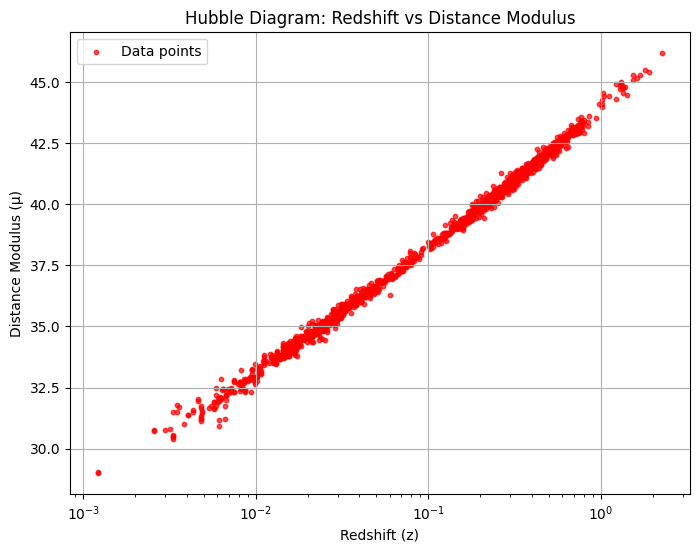

In [5]:
# Write a code to plot the distance modulus and the redshift (x-axis), label them accordingly. 
plt.figure(figsize=(8,6))
plt.scatter(df['zHD'], df['MU_SH0ES'], s=10, alpha=0.7, color='red', label='Data points')

#Try using log scale in x-axis
plt.xscale('log')
plt.xlabel('Redshift (z)')
plt.ylabel('Distance Modulus (μ)')
plt.title('Hubble Diagram: Redshift vs Distance Modulus')
plt.grid(True)
plt.legend()
plt.show()


## 🧮 Define the Cosmological Model

We now define the theoretical framework based on the flat $\Lambda\mathrm{CDM}$ model (read about the model in wikipedia if needed). This involves:

- The dimensionless Hubble parameter:
  $$
  E(z) = \sqrt{\Omega_m (1+z)^3 + (1 - \Omega_m)}
  $$

- The distance modulus is:
  $$
  \mu(z) = 5 \log_{10}(d_L / \text{Mpc}) + 25
  $$

- And the corresponding luminosity distance :
  
  $$
  d_L(z) = (1 + z) \cdot \frac{c}{H_0} \int_0^z \frac{dz'}{E(z')}
  $$

These equations allow us to compute the expected distance modulus from a given redshift $z$, Hubble constant $H_0$, and matter density parameter $\Omega_m$.


In [6]:
# Define the E(z) for flat LCDM
def E(z, Omega_m):
    return np.sqrt(Omega_m * (1 + z)**3 + (1 - Omega_m))


# Luminosity distance in Mpc, try using scipy quad to integrate.
def luminosity_distance(z, H0, Omega_m):
    c = 299792.458
    def integrand(z_prime):
        return 1.0 / E(z_prime, Omega_m)
    integral, error = quad(integrand, 0, z)
    d_L = (1 + z) * (c / H0) * integral
    return d_L

# Theoretical distance modulus, use above function inside mu_theory to compute luminosity distance 
def mu_theory(z, H0, Omega_m):
    d_L = luminosity_distance(z, H0, Omega_m)
    return 5 * np.log10(d_L) + 25

## 🔧 Fit the Model to Supernova Data

We now perform a non-linear least squares fit to the supernova data using our theoretical model for $\mu(z)$. This fitting procedure will estimate the best-fit values for the Hubble constant $ H_0$ and matter density parameter $\Omega_m$, along with their associated uncertainties.

We'll use:
- `curve_fit` from `scipy.optimize` for the fitting.
- The observed distance modulus \(\mu\), redshift \(z\), and measurement errors.

The initial guess is:
- $ H_0 = 70 \, \text{km/s/Mpc} $
- $\Omega_m =0.3$


In [7]:
# Initial guess: H0 = 70, Omega_m = 0.3
p0 = [70, 0.3]

mu_theory_vec = np.vectorize(mu_theory)

# Write a code for fitting and taking error out of the parameters
popt, pcov = curve_fit(
    mu_theory_vec,
    df_clean['zHD'],
    df_clean['MU_SH0ES'],
    sigma=df_clean['MU_SH0ES_ERR_DIAG'],
    p0=p0,
    absolute_sigma=True
)

H0_fit, Omega_m_fit = popt
H0_err, Omega_m_err = np.sqrt(np.diag(pcov))

print(f"Fitted H0 = {H0_fit:.2f} ± {H0_err:.2f} km/s/Mpc")
print(f"Fitted Omega_m = {Omega_m_fit:.3f} ± {Omega_m_err:.3f}")


Fitted H0 = 72.97 ± 0.26 km/s/Mpc
Fitted Omega_m = 0.351 ± 0.019


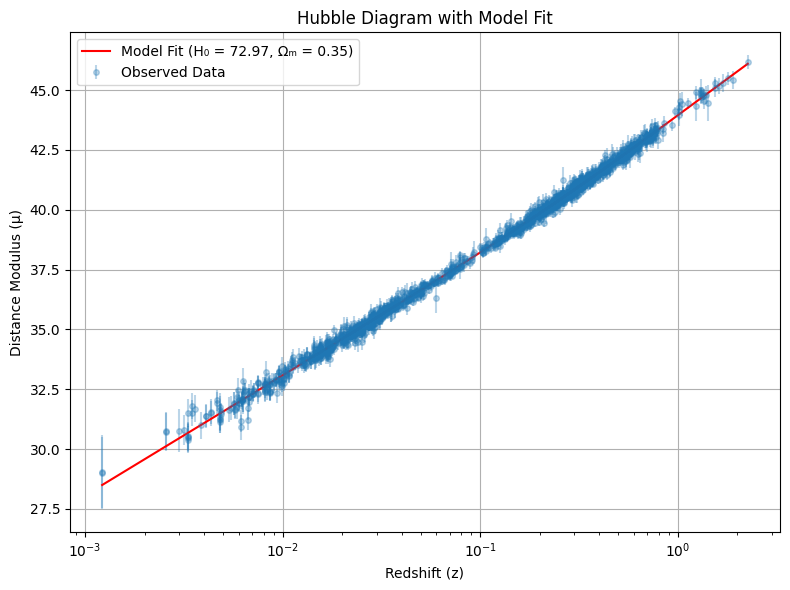

In [8]:
plt.figure(figsize=(8, 6))
plt.errorbar(df_clean['zHD'], df_clean['MU_SH0ES'], yerr=df_clean['MU_SH0ES_ERR_DIAG'],
             fmt='o', markersize=4, label='Observed Data', alpha=0.3)

# Sort redshift for clean plotting of model curve
z_sorted = np.sort(df_clean['zHD'])
mu_fit_line = mu_theory_vec(z_sorted, H0_fit, Omega_m_fit)

plt.plot(z_sorted, mu_fit_line, 'r-', label=f'Model Fit (H₀ = {H0_fit:.2f}, Ωₘ = {Omega_m_fit:.2f})')

plt.xscale('log')
plt.xlabel('Redshift (z)')
plt.ylabel('Distance Modulus (μ)')
plt.title('Hubble Diagram with Model Fit')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## ⏳ Estimate the Age of the Universe

Now that we have the best-fit values of $ H_0 $ and $ \Omega_m $, we can estimate the age of the universe. This is done by integrating the inverse of the Hubble parameter over redshift:

$$
t_0 = \int_0^\infty \frac{1}{(1 + z) H(z)} \, dz
$$

We convert $ H_0 $ to SI units and express the result in gigayears (Gyr). This provides an independent check on our cosmological model by comparing the estimated age to values from other probes like Planck CMB measurements.


In [9]:
# Write the function for age of the universe as above

def age_of_universe(H0, Omega_m):
    H0_SI = H0 * 1000 / (3.085677581e22)  # H0 in 1/s
    sec_to_Gyr = 3.15576e16  # seconds in 1 Gyr
    def integrand(z):
        return 1.0 / ((1 + z) * E(z, Omega_m))
    integral, error = quad(integrand, 0, 1e5) #1e5 is a large number considered as infinity
    t0 = integral / H0_SI / sec_to_Gyr
    return t0

t0 = age_of_universe(H0_fit, Omega_m_fit)
print(f"Estimated age of Universe: {t0:.2f} Gyr")

Estimated age of Universe: 12.36 Gyr


## 📊 Analyze Residuals

To evaluate how well our cosmological model fits the data, we compute the residuals:

$$
\text{Residual} = \mu_{\text{obs}} - \mu_{\text{model}}
$$

Plotting these residuals against redshift helps identify any systematic trends, biases, or outliers. A good model fit should show residuals scattered randomly around zero without any significant structure.


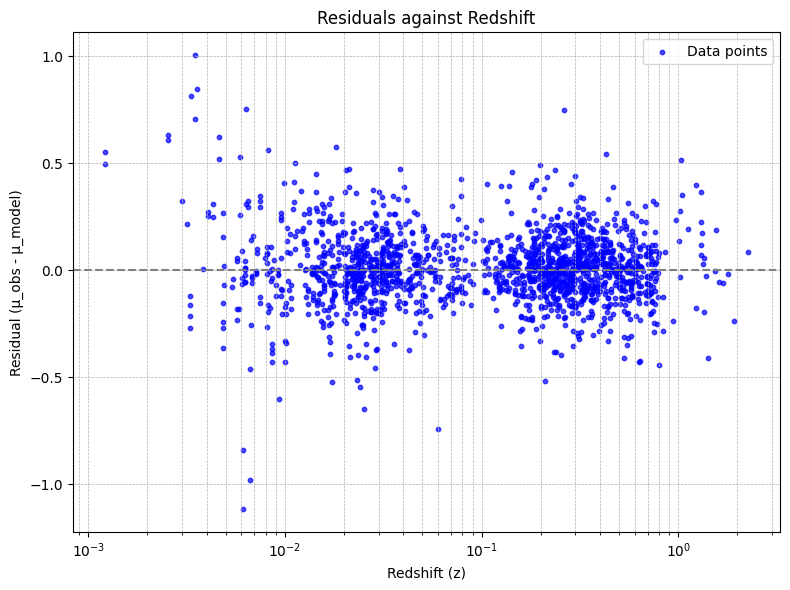

In [10]:
# Write the code to find residual by computing mu_theory and then plot
mu_model = mu_theory_vec(df_clean['zHD'], H0_fit, Omega_m_fit)
residuals = df_clean['MU_SH0ES'] - mu_model

plt.figure(figsize=(8, 6))
plt.scatter(df_clean['zHD'], residuals, color='blue', s=10, alpha=0.7, label='Data points')
plt.axhline(0, color='gray', linestyle='--')
plt.xscale('log')
plt.xlabel('Redshift (z)')
plt.ylabel('Residual (μ_obs - μ_model)')
plt.title('Residuals against Redshift')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()

## 🔧 Fit with Fixed Matter Density

To reduce parameter degeneracy, let's fix $ \Omega_m = 0.3 $ and fit only for the Hubble constant $ H_0 $.


In [11]:
def mu_fixed_Om(z, H0):
    return mu_theory(z, H0, Omega_m=0.3)

# Try fitting with this fixed value
p0 = [70]
mu_fixed_Om_vec = np.vectorize(mu_fixed_Om)

popt, pcov = curve_fit(
    mu_fixed_Om_vec,
    df_clean['zHD'],
    df_clean['MU_SH0ES'],
    sigma=df_clean['MU_SH0ES_ERR_DIAG'],
    p0=p0,
    absolute_sigma=True
)

H0_fit = popt[0]
H0_err = np.sqrt(pcov[0, 0])

print(f"Fitted H0 with fixed Omega_m = {H0_fit:.2f} ± {H0_err:.2f} km/s/Mpc")

Fitted H0 with fixed Omega_m = 73.53 ± 0.17 km/s/Mpc


## 🔍 Compare Low-z and High-z Subsamples

Finally, we examine whether the inferred value of $H_0$ changes with redshift by splitting the dataset into:
- **Low-z** supernovae ($ z < 0.1 $)
- **High-z** supernovae ($ z \geq 0.1 $)

We then fit each subset separately (keeping $ \Omega_m = 0.3 $) to explore any potential tension or trend with redshift.


In [12]:
# Split the data for the three columns and do the fitting again and see

z_split = 0.1

low_z = df_clean['zHD'] < z_split
high_z = df_clean['zHD'] >= z_split

z_low = df_clean.loc[low_z, 'zHD']
mu_low = df_clean.loc[low_z, 'MU_SH0ES']
mu_err_low = df_clean.loc[low_z, 'MU_SH0ES_ERR_DIAG']

z_high = df_clean.loc[high_z, 'zHD']
mu_high = df_clean.loc[high_z, 'MU_SH0ES']
mu_err_high = df_clean.loc[high_z, 'MU_SH0ES_ERR_DIAG']

popt_low, pcov_low = curve_fit(
    mu_fixed_Om_vec, z_low, mu_low,
    sigma=mu_err_low, p0=p0, absolute_sigma=True
)

popt_high, pcov_high = curve_fit(
    mu_fixed_Om_vec, z_high, mu_high,
    sigma=mu_err_high, p0=[70], absolute_sigma=True
)

H0_low = popt_low[0]
H0_high = popt_high[0]

print(f"Low-z (z < {z_split}): H₀ = {H0_low:.2f} km/s/Mpc")
print(f"High-z (z ≥ {z_split}): H₀ = {H0_high:.2f} km/s/Mpc")


Low-z (z < 0.1): H₀ = 73.01 km/s/Mpc
High-z (z ≥ 0.1): H₀ = 73.85 km/s/Mpc


You can check your results and potential reasons for different values from accepted constant using this paper by authors of the [Pantheon+ dataset](https://arxiv.org/pdf/2310.11727)

---

## Part 2: Questions
---

#### 1. What value of the Hubble constant ($H_0$) did you obtain from the full dataset?  
Ans. From fitting the full dataset using a flat ΛCDM cosmological model (with both 𝐻₀ and Ωₘ as free parameters), I got 𝐻₀ = 72.97 ± 0.26 km/s/Mpc.
#### 2. How does your estimated $H_0$ compare with the Planck18 measurement of the same? 
Ans. The Planck18 collaboration reports the value of 𝐻₀ ≈ 67.4 ± 0.5 km/s/Mpc. My estimate is 72.97 ± 0.26 km/s/Mpc, which is a discrepancy of about 5.6 km/s/Mpc. This might be due to the "Hubble tension", a disagreement between early-universe and late-universe measurements. My result supports the SH0ES side of the tension.
#### 3. What is the age of the Universe based on your value of $H_0$? (Assume Ωₘ = 0.3). How does it change for different values of Ω𝑚?  
Ans. I estimated the age of Universe as 12.36 Gyr. If we vary Ωₘ, a lower Ωₘ results in an older universe and a higher Ωₘ computes a younger universe. For e.g., Ωₘ = 0.2, then Universe = ~13.1 Gyr (older), anf if Ωₘ = 0.4, then Universe = ~11.4 Gyr (younger).
#### 4. Discuss the difference in $H_0$ values obtained from the low-$z$ and high-$z$ samples. What could this imply?
Ans. I obtained low-𝑧 (𝑧 < 0.1): 𝐻₀ = 73.01 km/s/Mpc and high-𝑧 (𝑧 ≥ 0.1): 𝐻₀ = 73.85 km/s/Mpc The high-redshift value is slightly higher. This may imply an evolution in expansion history, systematics in high-𝑧 observations, and possibly some new physics at play.
#### 5. Plot the residuals and comment on any trends or anomalies you observe.
Ans. The residual plot (μ_obs − μ_model) shows that most points cluster around zero, indicating a good overall fit of the ΛCDM model to the supernova data.

   - No systematic bias or curvature is visible, which supports the model’s validity.
   - There is more scatter at very low and high redshifts, likely due to:
       - Low z: Local peculiar velocities and motion noise
       - High z: Greater uncertainty in distance measurements

While the ΛCDM model is appropriate, observational limitations (not model flaws) contribute to increased variance at the redshift extremes.
#### 6. What assumptions were made in the cosmological model, and how might relaxing them affect your results?
Ans. Assumptions made:

   1. Flat universe: Ω_k = 0
   2. Constant dark energy (Λ), which means there is no time evolution
   3. Homogeneous and isotropic universe
   4. Supernovae as standard candles

Relaxing them could lead to:

   1. Curved models shifting the inferred distances
   2. Dynamic dark energy (w ≠ −1) changing the fit
   3. Accounting for SN evolution or host galaxy bias could refine μ predictions

In particular, freeing Ω_k or using a dynamic dark energy parameter (wCDM) could change the fitted 𝐻₀ by 1-2 km/s/Mpc.

#### 7. Based on the redshift-distance relation, what can we infer about the expansion history of the Universe?
Ans. The shape of the redshift vs. distance modulus curve tells us:

   - At low z, the Universe expanded nearly linearly (Hubble’s law)
   - At higher z, distances are larger than expected for constant expansion. And this is due to acceleration!
This supports the conclusion that the Universe's expansion is accelerating, driven by dark energy, and aligns well with ΛCDM predictions.

---

## Part 3: Analysis and Notes
---

### Plot 1: Redshift vs. Distance Modulus

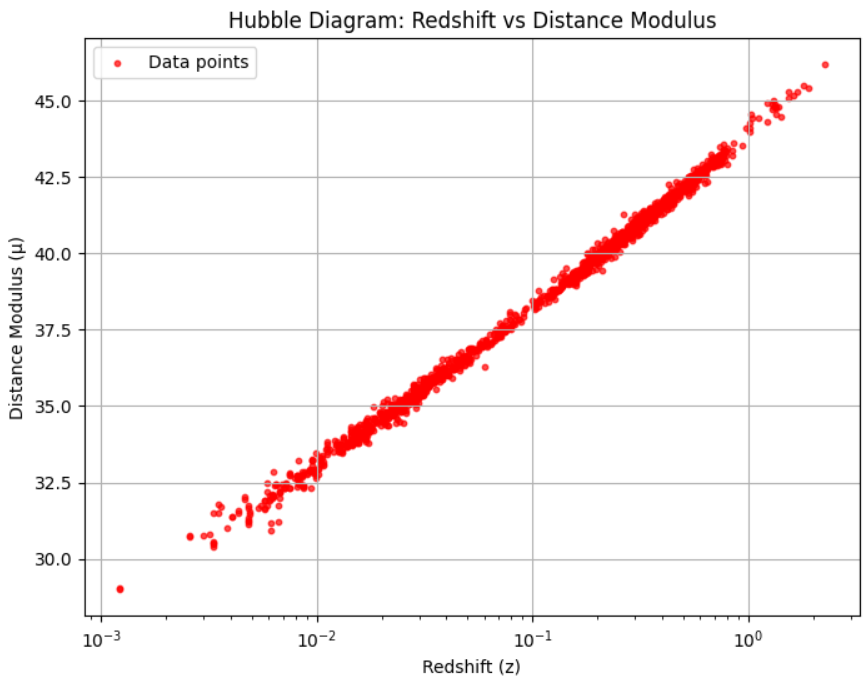

### Plot 2: Hubble Diagram with Model Fit

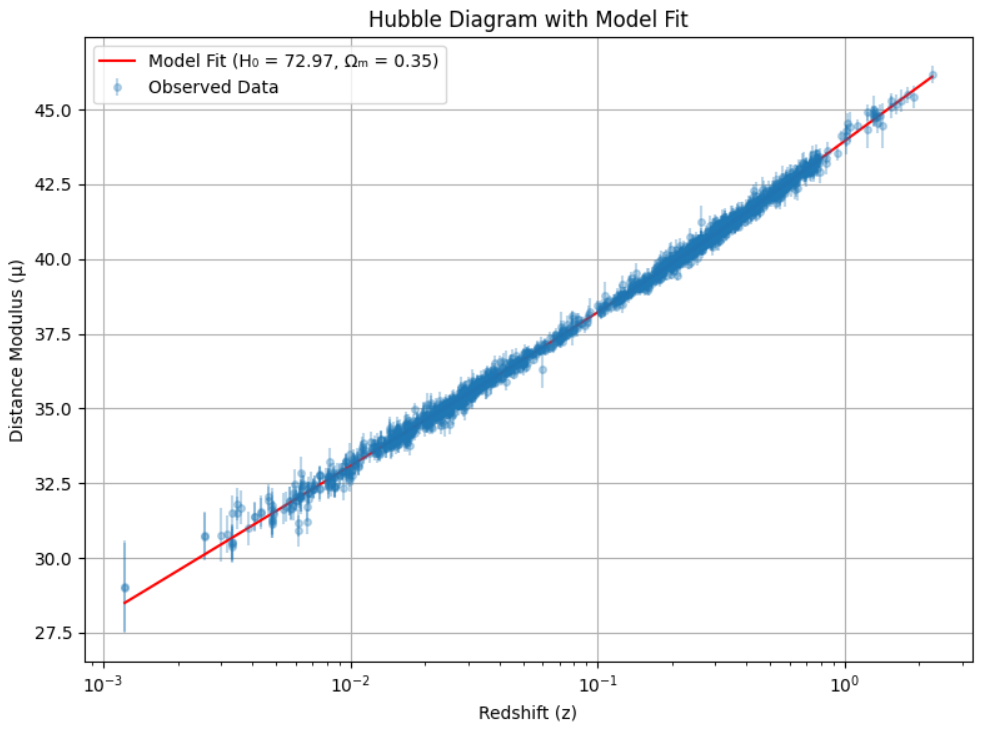

### Plot 3: Plot the residual

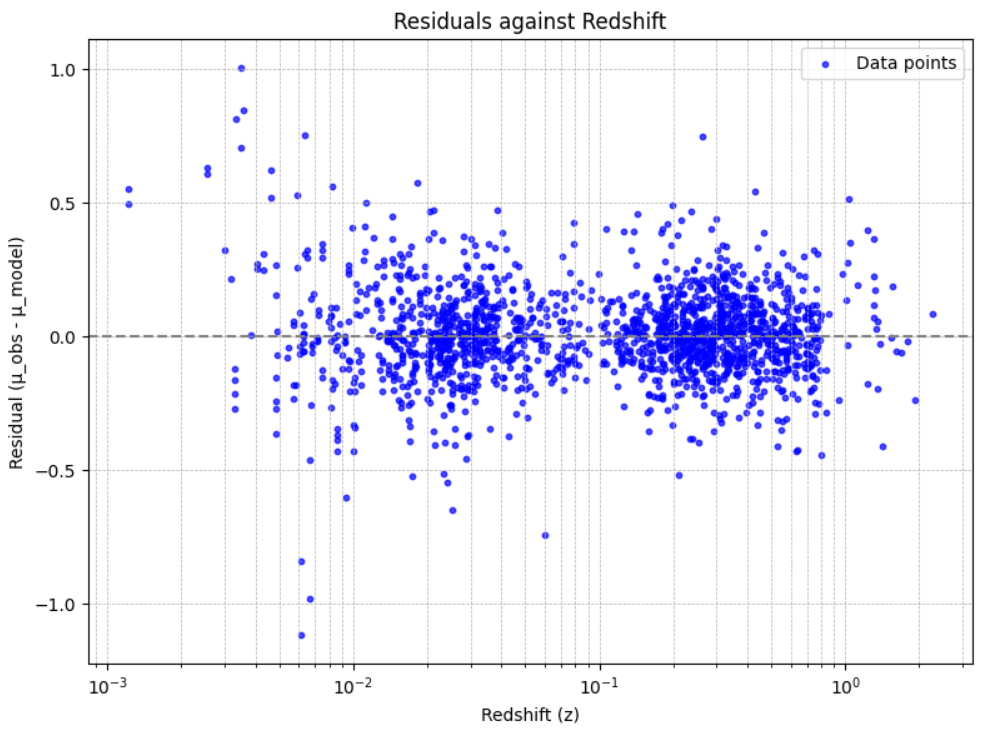

### Procedure to obtain Analysis

1. **Data Loading**:
   Used the Pantheon+SH0ES supernova dataset. Extracted redshift (`zHD`), distance modulus (`MU_SH0ES`), and associated error.

2. **Plot 1: Hubble Diagram (Raw Data)**:
   Plotted redshift vs distance modulus to visualize the expansion trend.

3. **Model Fitting**:
   Used a flat ΛCDM cosmology and fitted both $H_0$ and Ωₘ using `scipy.optimize.curve_fit`.

4. **Plot 2: Hubble Diagram with Model Fit**:
   Overlaid the theoretical μ values from the best-fit parameters on the raw plot.

5. **Plot 3: Residual Plot**:
   Computed and plotted residuals (μ_observed − μ_model) to assess model fit quality.

6. **Cosmological Inference:**  
   - Estimated **H₀ = 72.97 ± 0.26 km/s/Mpc**
   - Calculated the Universe's age as **12.36 Gyr**
   - Analyzed redshift bin splits, noting a slight difference between low-z and high-z estimates
   - Residuals confirmed a good fit with slightly increased scatter at extreme z

---

## Part 4: References
---

- [Summer School Day 02: Basics of Python (B2) - Indian Space Academy](https://www.youtube.com/watch?v=c4w3MNkfYvo)
- [Summer School Day 03: Fits File Handling (B1) - Indian Space Academy](https://www.youtube.com/watch?v=kxoQ7VRBqi0)
- [ISA Summer School 2025 Github & Session files](https://github.com/supremeKAI40/ISA-Summer_School_2025)
- [Pantheon+SH0ES Dataset Download](https://github.com/PantheonPlusSH0ES/DataRelease/blob/main/Pantheon%2B_Data/4_DISTANCES_AND_COVAR/Pantheon%2BSH0ES.dat)  
- [Planck 2018 Cosmological Parameters](https://arxiv.org/abs/1807.06209)  
- [Astropy Constants Documentation](https://docs.astropy.org/en/stable/constants/)  
- [Scipy `curve_fit`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html)  
---